In [1]:
from keras.models import Sequential,Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers import Embedding,GRU,TimeDistributed,RepeatVector,Merge,BatchNormalization,Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Embedding,LSTM,GRU,TimeDistributed,RepeatVector,Merge,Input,merge,UpSampling2D
from keras.preprocessing import sequence
from keras import callbacks
from keras.optimizers import SGD, RMSprop, Adam

import numpy as np
from vgg16 import Vgg16
import matplotlib.pyplot as plt
import PIL.Image

from tqdm import tqdm

from utils import *

import cPickle as pickle
import string

import collections
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

import re
from numpy.random import random, permutation, randn, normal 

import os

import preprocessing as preproc

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from matplotlib import animation
from IPython.display import display, HTML

import pandas as pd
import languageUtils
import nnModel
import nnModel_no_feedback
import plotter
import videoExplorer as vidExplorer

Using Theano backend.
Using gpu device 0: GeForce GTX 1080 (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
base_path = data_path+"app-100-length-15/"

train_path = base_path + train_folder
val_path = base_path + val_folder

NR_TRAIN_EXAMPLES = 219136
NR_TEST_EXAMPLES = 28858
SMALL_NR_TEST_EXAMPLES = 1000

# Read Serialized Data - Images

In [3]:
test_images_concat_t = preproc.get_images_concat(
    val_path + images_concat_folder+ 'images_concat_0.bc',
    SMALL_NR_TEST_EXAMPLES)

print(test_images_concat_t.shape)

(1000, 3, 224, 224)


# Load precomputed misc data structures

In [4]:
train_img_vgg_path = base_path + train_folder + batch_folder + images_vgg_4096_folder
train_indexed_captions_path = base_path + train_folder + batch_folder + indexed_captions_folder
train_raw_captions_path = base_path + train_folder + batch_folder + captions_folder
train_future_words_path = base_path + train_folder + batch_folder + indexed_future_words_folder

test_img_vgg_path = base_path + val_folder + batch_folder +images_vgg_4096_folder
test_indexed_captions_path = base_path + val_folder + batch_folder + indexed_captions_folder
test_raw_captions_path = base_path + val_folder + batch_folder+captions_folder
test_future_words_path = base_path + val_folder + batch_folder+indexed_future_words_folder


train_prev_captions_path = base_path + train_folder + batch_folder + indexed_prev_captions_folder
test_prev_captions_path = base_path + val_folder + batch_folder + indexed_prev_captions_folder



In [5]:
(unique_words, word2index, index2word) = languageUtils.load_language_data_structures(base_path + general_datastruct_folder)

(train_captions_raw,_) = preproc.get_captions_raw_and_indexed(train_raw_captions_path,train_indexed_captions_path)
(test_captions_raw,_) = preproc.get_captions_raw_and_indexed(test_raw_captions_path,test_indexed_captions_path)


100%|██████████| 11/11 [00:00<00:00, 32.30it/s]


In [6]:
EMB_SIZE = 300
VOCAB_SIZE = len(unique_words)
MAX_CAPTION_LEN = 15 # ATENTIE AICI


print("MAX_CAPTION_LEN = %s"%MAX_CAPTION_LEN)
print("VOCAB_SIZE = %s"%VOCAB_SIZE)

MAX_CAPTION_LEN = 15
VOCAB_SIZE = 849


# Model Building

In [7]:
emb = nnModel.get_embeddings(index2word, VOCAB_SIZE, EMB_SIZE)
model = nnModel.build_model(emb,MAX_CAPTION_LEN, VOCAB_SIZE, EMB_SIZE)
# model = nnModel_no_feedback.build_model(emb,MAX_CAPTION_LEN, VOCAB_SIZE, EMB_SIZE)

Found = 840
Not found = 8


In [ ]:
model.summary()

# Training the model

In [ ]:
history = model.fit_generator(
                    nnModel.generate_arrays_from_file(train_img_vgg_path,train_indexed_captions_path,
                                              train_future_words_path,train_prev_captions_path),
                    samples_per_epoch = 219136,
                    nb_epoch=1,
                    validation_data = nnModel.generate_arrays_from_file(test_img_vgg_path,test_indexed_captions_path,
                                                   test_future_words_path,test_prev_captions_path),
                    nb_val_samples = 2048,
                    callbacks=[#callbacks.RemoteMonitor(),
                               callbacks.CSVLogger("./training.log")]
                   )

In [ ]:
model.evaluate_generator(nnModel.generate_arrays_from_file(test_img_vgg_path,test_indexed_captions_path,
                                                   test_future_words_path,test_prev_captions_path),
                         val_samples = 2048)

In [ ]:
# model.save_weights(save_path + models_folder+"big/" +'app_100_length_15_past_word_30_epoch_300d_gru_2x1048_big.h5')

In [8]:
model.load_weights(save_path + models_folder+"big/" +'app_100_length_15_past_word_20_epoch_300d_gru_2x1048_big.h5')

# Training the model no feedback

In [ ]:
history = model.fit_generator(
                    nnModel_no_feedback.generate_arrays_from_file(train_img_vgg_path,train_indexed_captions_path,
                                              train_future_words_path),
                    samples_per_epoch = 219136,
                    nb_epoch=5,
                    validation_data = nnModel_no_feedback.generate_arrays_from_file(test_img_vgg_path,test_indexed_captions_path,
                                                   test_future_words_path),
                    nb_val_samples = 2048,
                    callbacks=[#callbacks.RemoteMonitor(),
                               callbacks.CSVLogger("./training.log")]
                   )

In [ ]:
model.save_weights(save_path + models_folder+"big/" +'app_100_length_15_past_word_30_epoch_300d_gru_2x1048_big_no_feedback.h5')

In [ ]:
model.evaluate_generator(nnModel_no_feedback.generate_arrays_from_file(train_img_vgg_path,
                                                   train_indexed_captions_path,
                                                   train_future_words_path),
                        val_samples = NR_TRAIN_EXAMPLES,
                        )

In [ ]:
model.evaluate_generator(nnModel_no_feedback.generate_arrays_from_file(test_img_vgg_path,
                                                   test_indexed_captions_path,
                                                   test_future_words_path),
                        val_samples = NR_TEST_EXAMPLES)

# Evaluate the model

In [ ]:
model.evaluate_generator(nnModel.generate_arrays_from_file(train_img_vgg_path,
                                                   train_indexed_captions_path,
                                                   train_future_words_path,
                                                   train_prev_captions_path),
                        val_samples = NR_TRAIN_EXAMPLES,
                        )

In [ ]:
model.evaluate_generator(generate_arrays_from_file(test_img_vgg_path,
                                                   test_indexed_captions_path,
                                                   test_future_words_path,
                                                   test_prev_captions_path),
                        val_samples = NR_TEST_EXAMPLES)

# Testing the model

In [17]:
window_start = 0
nr_images = 50

# images_concat_t = train_images_concat_t #ATENTIE
# real_captions = train_captions_raw

images_concat_t = test_images_concat_t
real_captions = languageUtils.strip_caption_list(test_captions_raw)

print(images_concat_t.shape)

# (images,predicted_captions) = nnModel.make_prediction_on_dataset(images_concat_t,window_start,nr_images)
(images,predicted_captions) = nnModel.make_prediction_on_dataset(images_concat_t,model,word2index,index2word,MAX_CAPTION_LEN,window_start,nr_images)

(1000, 3, 224, 224)


100%|██████████| 50/50 [00:07<00:00,  6.97it/s]


In [ ]:
# merged_captions = [str(a) +" ------ " + str(b)  for a,b in zip(predicted_captions,real_captions)]
# merged_captions[:10]

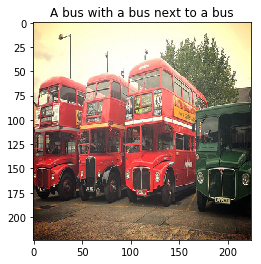

In [23]:
plotter.plot_predictions(images[:1],titles = ["A bus with a bus next to a bus"])

In [ ]:
common_words2app = languageUtils.most_common_words(predicted_captions,500)
common_words2app[:5]

In [ ]:
searched_word = "wave"
(found_images,found_captions,_) = vidExplorer.search_video_by(searched_word,images,predicted_captions)
print("Number of results = %d"%len(found_images))

In [ ]:
plotter.plot_predictions(found_images,found_captions)

# Make predictions on misc dataset

In [11]:
misc_images_path = save_path + misc_images_folder

In [12]:
misc_images = []
for img_path in os.listdir(misc_images_path):
    img = PIL.Image.open(misc_images_path+img_path)
    img = img.resize((224, 224), PIL.Image.NEAREST)
    img = np.asarray(img)
    img = np.transpose(img,(2,0,1))
    img = np.expand_dims(img,axis=0)
    
    misc_images.append(img)
    
stacked_images = np.vstack(misc_images)

In [14]:
(misc_images,misc_predicted_captions) = make_prediction_on_dataset(stacked_images)
preproc.plot_predictions(misc_images,misc_predicted_captions)

AttributeError: 'module' object has no attribute 'make_prediction_on_dataset'

## Prepare data for "Caption Turing Test"

In [ ]:
def get_all_captions(image_data_arr):
    caption_bucket_list = preproc.get_captions_list(image_data_arr)
    caption_bucket_length = len(caption_bucket_list[0])
    
    captions = np.stack(caption_bucket_list)
    
    print("caption_bucket_length = %d"%caption_bucket_length)
    print("captions.shape = %s"%str(captions.shape))
    
    return (caption_bucket_list)


def get_imgs_and_captions(base_images_path,base_annotation_path,nr_items):
    image_data_arr = preproc.get_image_data_arr(base_images_path,base_annotation_path,nr_items)
    
    captions= get_all_captions(image_data_arr)
    images = preproc.construct_images_concat_t(image_data_arr)
    
    print("images.shape = %s"%str(images.shape))
    return (images,captions)
    
    

In [ ]:
base_images_path = val_images_path
base_annotation_path = val_annotation_path

(images,caption_bucket_list) = get_imgs_and_captions(base_images_path,base_annotation_path,100)

In [ ]:
(_,predicted_captions) = make_prediction_on_dataset(images,0,99)

In [ ]:
real_captions_1 = strip_caption_list(caption_bucket_list[0])
real_captions_2 = strip_caption_list(caption_bucket_list[1])

In [ ]:
turing_df = percentile_list = pd.DataFrame(
    {'image': list(images),
     'predicted_caption': predicted_captions,
     'real_caption_1': real_captions_1,
     'real_caption_2': real_captions_2
    })

In [ ]:
turing_df.head()